# SMOTE
*Implementation from scratch*

—<br><font size=5><b>T</b></font>his notebook contains my own trial to create an SMOTE model for data interpolation or data generation from scratch. I have read the theory on this technique and on my thoughts, I will be creating the SMOTE algorithm as the class. This notebook is for me (personally) but if you are someone other than me you can read it too as I have provided clear syntax and explanation.

***NOTE***: After many trials and comparisions between my implementation and the official implementation from `imblearn's SMOTE` I am going to create this book. Not all features from imblearn will be implemented but the one that I am going to build will be pretty usefull to work with.

Let's get started.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

We generate the data on the line between 2 points. In smote there will be always 2 points on which the data will be generated. So, it will sound like a ***linear regression*** and yes it is! 

Let's see what happens if we only have 2 features and have to find the line between 2 points. So, we will have to find Slope and Intercept.

### Slope

# $$ \text{slope} = \frac {y_2 - y_1} {x_2 - x_1} $$
This is main thing. Slope. We will require to generate data on the line.

#### Intercept

# $$ \text{intercept} = \bar y - \text{slope} \times \bar x $$

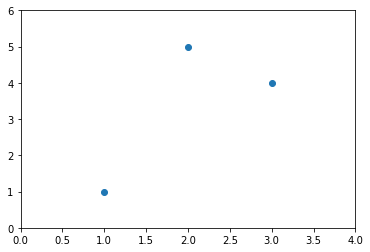

In [3]:
# A fake data generation for testing
x = [1, 3, 2]
y = [1, 4, 5]

plt.scatter(x, y)
plt.xlim([0, 4])
plt.ylim([0, 6]);

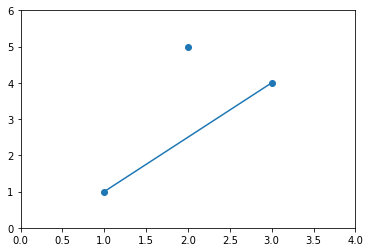

In [3]:
x1 = 1; y1 = 1 
x2 = 3; y2 = 4

plt.scatter(x, y)
plt.plot([x1, x2], [y1, y2])
plt.xlim([0, 4])
plt.ylim([0, 6]);

In [4]:
# Will return B0 = intercept and B1 = slope
def B0_B1(x1, x2, y1, y2):
    B1 = (y2 - y1) / (x2 - x1)
    B0 = ((y1 + y2) / 2) - (B1 * ((x1 + x2) / 2))
    return B0, B1

In [5]:
B0_B1(x1, x2, y1, y2)

(-0.5, 1.5)

In [6]:
# This is the "model" which will return y based on x
def generator(x, B0, B1):
    return B0 + x * B1

In [7]:
syntehsized = []
for i in range(10):
    randx = np.random.uniform(x1, x2)          #  B0, B1
    syntehsized.append((randx, generator(randx, -0.5, 1.5)))

In [8]:
syntehsized = np.array(syntehsized)
new_x = syntehsized[:, 0]
new_y = syntehsized[:, 1]

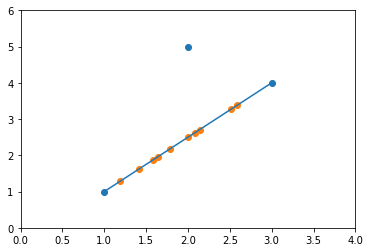

In [9]:
x1 = 1; y1 = 1 
x2 = 3; y2 = 4

plt.scatter(x, y)
plt.plot([x1, x2], [y1, y2])
plt.scatter(new_x, new_y)
plt.xlim([0, 4])
plt.ylim([0, 6]);

Great! That was the simple linear regression problem. Let's try to make it for all!

In [2]:
from itertools import combinations

In [11]:
# Now, we will do for each pair of points
syntehsized = []
for (x1, y1), (x2, y2) in combinations([*zip(x, y)], 2):
    B0, B1 = B0_B1(x1, x2, y1, y2)
    for i in range(10):
        randx = np.random.uniform(x1, x2)
        syntehsized.append((randx, generator(randx, B0, B1)))

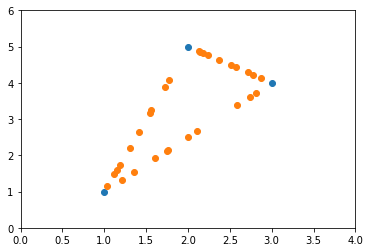

In [12]:
syntehsized = np.array(syntehsized)
new_x = syntehsized[:, 0]
new_y = syntehsized[:, 1]

plt.scatter(x, y)
plt.scatter(new_x, new_y)
plt.xlim([0, 4])
plt.ylim([0, 6]);

Pretty neat! Now, let's try it on some other big dataset.

In [13]:
# On some more data...
x = np.random.randint(0, 100, 20)
y = np.random.randint(0, 100, 20)

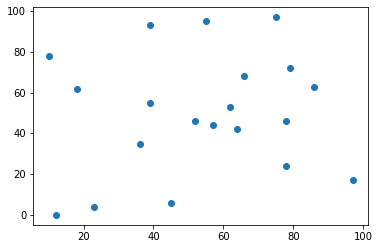

In [14]:
plt.scatter(x, y)

<ipython-input-4-149a1e2b993e>:2: RuntimeWarning: divide by zero encountered in long_scalars
  B1 = (y2 - y1) / (x2 - x1)
<ipython-input-6-8e88e929a601>:2: RuntimeWarning: invalid value encountered in double_scalars
  return B0 + x * B1


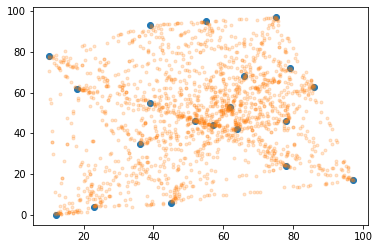

In [15]:
# Same thing repeats...

syntehsized = []
for (x1, y1), (x2, y2) in combinations([*zip(x, y)], 2):
    B0, B1 = B0_B1(x1, x2, y1, y2)
    for i in range(10):
        randx = np.random.uniform(x1, x2)
        syntehsized.append((randx, generator(randx, B0, B1)))
        
syntehsized = np.array(syntehsized)
new_x = syntehsized[:, 0]
new_y = syntehsized[:, 1]

plt.scatter(x, y)
plt.scatter(new_x, new_y, marker=".", alpha=0.2)

Yeah, I know it tries to draw new 10 samples in between each possible connection. So it looks like this. But the thing is different in SMOTE, in SMOTE - we choose randomly a single point from selected `k` points and then draw a connection there. 

## Getting eager. 
Let's implement directly as a class. 

In [26]:
# A data with 3 features 1000 rows and 4 classes

df = pd.DataFrame({"x1": np.random.randint(0, 100, 1000),
                   "x2": np.random.randint(0, 100, 1000),
                   "x3": np.random.randint(0, 100, 1000),
                   "y": np.random.choice(["A", "B", "C", "D"], 1000)})

In [21]:
class SMOTE:
    """
    oversampling size: how much of the y (the maximum count of class)
    """
    def __init__(self, X, y, oversampling_size=1):
        # Simple array transformation
        self.X = np.array(X)
        self.y = np.array(y)
        
        # The length and compatibility checks
        if self.X.ndim != 2:
            raise NotImplementedError("The dimention of X must be 2D.")
        
        if self.X.shape[0] != len(self.y):
            raise NotImplementedError("Length X and Y mismatched.")
        
        if not 0 < oversampling_size <= 1:
            raise NotImplementedError("Oversampling size must be in between 0 to 1.")
        
        # Unique classes and their respective counts
        self.unique_classes, self.unique_count = np.unique(self.y, return_counts=True)
        
        # The max frequency found and multiplied
        # for target frequency generation
        self.to_sample = int(self.unique_count.max() * oversampling_size)
        
        # Total unique classes
        self.nunique = len(self.unique_classes)
        # Total classes which needs oversampling (usually n - 1)
        self.new_generatable = (~(self.unique_count == self.to_sample)).sum()
        
        # Main class with highest freq 
        # (found that 'cause it will be used in next line)
        self.main_class = self.unique_classes[self.unique_count.argmax()]
        # Name of classes to resample (Except the main class)
        self.classes_to_resample = self.unique_classes[self.unique_classes != self.main_class]
        
    
    def resample(self, k=5):
        # Will iterate through gereratable classes
        for class_ in self.classes_to_resample:
            print(class_)
            print()
            # Filter rows to just *that* class
            X_mini = self.X[self.y == class_]
            
            # Fetch class count so we know how much to generate
            class_count = self.unique_count[np.where(self.unique_classes)[0][0]]
            generate_this_many = self.to_sample - class_count
            
            # Hey, this ↓ should be true.
            assert generate_this_many <= self.to_sample
            new_x, new_y = self.oversample(X_mini, k)
    
    
    def oversample(self, X_mini, k):
        # One random row
        random_idx = np.random.randint(0, X_mini.shape[0])
        row = X_mini[random_idx]
        
        # All distances from that row
        distances = ((row - X_mini) ** 2).sum(1) ** 0.5
        
        # `k` neighbours (except itself) 
        sorted_idxes = distances.argsort()[1:k+1]
        k_neighbours = X_mini[sorted_idxes]
        
        # Now picking 1 random neighbor
        rand_neighbour = np.random.randint(0, k)
        neighbour = k_neighbours[rand_neighbour]
        
        # We have point A's corrs (features)
        # And poinf B's corrs (features)
        B0, *Bi = self.get_regression_line(row, neighbour)
        return new_x, new_y
        
    
    def get_regression_line(self, A, B):
        pass
    
        
    def __repr__(self):
        return \
        f"""
        Number of features: {self.X.shape[1]}
        Total unique classes: {self.nunique}
        New instances to generate for: {self.new_generatable} class(s)
        Total class balance: {self.to_sample}
        Class with highest instances: {self.main_class}
        """

The class's ↑ implementation ***is not complete***. After some trials below ↓ I will continue implementing the class. I will use the copy of the code above.

See some experiments I've done below ↓

In [27]:
resampler = SMOTE(df[["x1", "x2", "x3"]], df.y)

In [28]:
resampler


        Number of features: 3
        Total unique classes: 4
        New instances to generate for: 3 class(s)
        Total class balance: 262
        Class with highest instances: D
        

In [175]:
from mpl_toolkits import mplot3d

In [176]:
X = np.random.randint(0, 10, 5)
Y = np.random.randint(0, 10, 5)
Z = np.random.randint(0, 10, 5)

In [204]:
%matplotlib

Using matplotlib backend: Qt5Agg


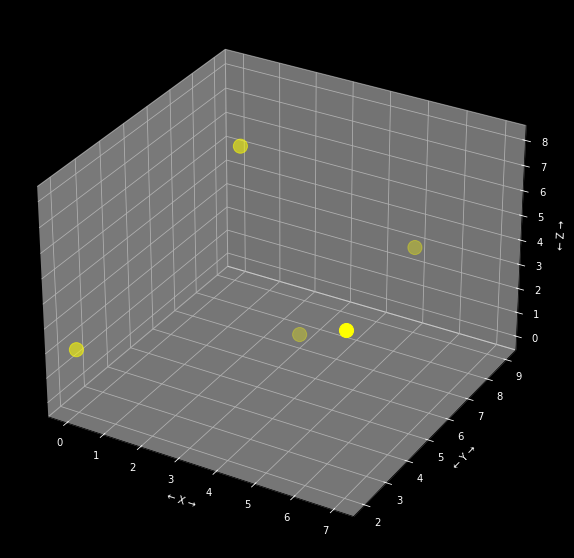

In [178]:
plt.rcParams["xtick.color"] = "white"
plt.figure(figsize=(10, 10), facecolor="black")
ax = plt.axes(projection= '3d', facecolor="black")
ax.scatter3D(X, Y, Z, color="yellow", s=200)
ax.set_xlabel("← X →", color="white")
ax.set_ylabel("← Y →", color="white")
ax.set_zlabel("← Z →", color="white");

In [63]:
from sklearn.linear_model import LinearRegression

In [217]:
row = np.c_[X[:2], Y[:2]]
row_y = Z[:2]

In [219]:
row

array([[5, 9],
       [7, 2]])

In [220]:
row_y

array([3, 6])

In [221]:
model = LinearRegression()
model.fit(row, row_y)

LinearRegression()

In [223]:
B0 = model.intercept_
Bi = model.coef_

In [224]:
(B0, Bi)

(6.0, array([ 0.11320755, -0.39622642]))

In [225]:
coord = []
for xi in range(row.shape[1]):
    from_ = row[0, xi]
    to_ = row[1, xi]
    coord.append(np.linspace(from_, to_))

In [226]:
new = np.c_[coord[0], coord[1]]

In [227]:
def generator(row, B0, Bi):
    return B0 + (row * Bi).sum(1)

In [228]:
z = generator(new, B0, Bi)

In [229]:
corr = np.c_[new, z]

In [230]:
x, y, z = corr[:, 0], corr[:, 1], corr[:, 2]

In [232]:
%matplotlib inline

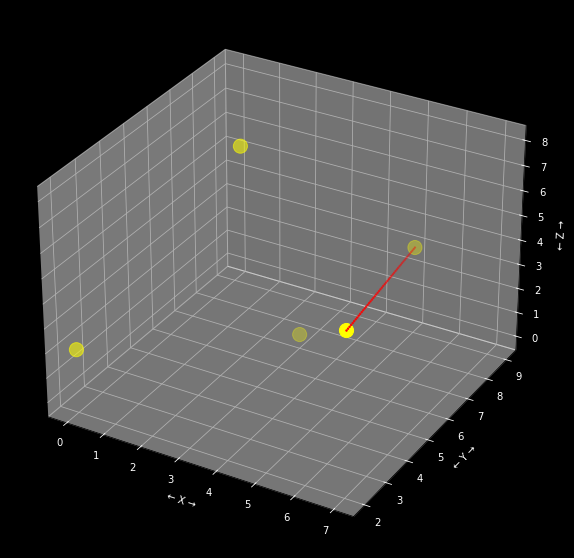

In [233]:
plt.rcParams["xtick.color"] = "white"
plt.figure(figsize=(10, 10), facecolor="black")
ax = plt.axes(projection= '3d', facecolor="black")
ax.scatter3D(X, Y, Z, color="yellow", s=200)
ax.scatter3D(x, y, z, color="red", s=2)
ax.set_xlabel("← X →", color="white")
ax.set_ylabel("← Y →", color="white")
ax.set_zlabel("← Z →", color="white");

In [234]:
from itertools import combinations

In [258]:
# As we did for 2 featured data, now for all datapoints in 3 featured data

def find_smotes(X, Y, Z):
    model = LinearRegression()
    new_corrs = None
    for row in combinations([*zip(X, Y, Z)], 2):
        row = np.array(row)
        features = row[:, :-1]
        target = row[:, -1]

        model.fit(features, target)
        B0 = model.intercept_
        Bi = model.coef_

        coord = []
        for xi in range(row.shape[1]):
            from_ = row[0, xi]
            to_ = row[1, xi]
            coord.append(np.linspace(from_, to_))

        new = np.c_[coord[0], coord[1]]    
        z = generator(new, B0, Bi)
        corr = np.c_[new, z]
        x, y, z = corr[:, 0], corr[:, 1], corr[:, 2]
        if not new_corrs is None:
            new_corrs = np.r_[new_corrs, np.c_[x, y, z]]
        else:
            new_corrs = np.c_[x, y, z]
    return new_corrs

In [260]:
new_corrs = find_smotes(X, Y, X)

In [251]:
x, y, z = new_corrs[:, 0], new_corrs[:, 1], new_corrs[:, 2]

In [287]:
%matplotlib inline

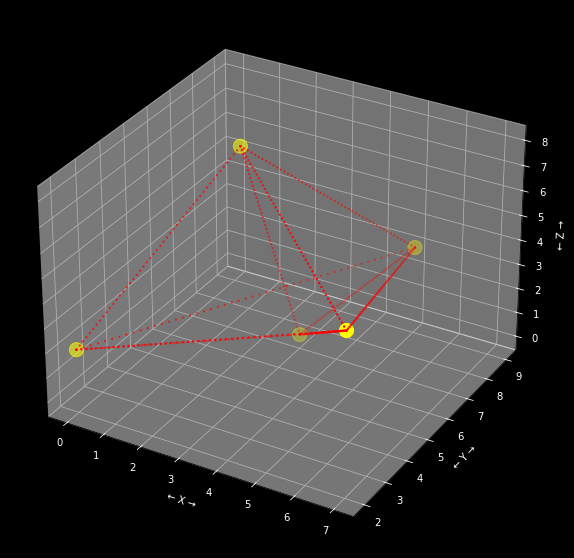

In [256]:
plt.rcParams["xtick.color"] = "white"
plt.figure(figsize=(10, 10), facecolor="black")
ax = plt.axes(projection= '3d', facecolor="black")
ax.scatter3D(X, Y, Z, color="yellow", s=200)
ax.scatter3D(x, y, z, color="red", s=2)
ax.set_xlabel("← X →", color="white")
ax.set_ylabel("← Y →", color="white")
ax.set_zlabel("← Z →", color="white");

## Wooh!!!

In [280]:
df = pd.DataFrame({"x1": np.random.randint(0, 100, 30),
                   "x2": np.random.randint(0, 100, 30),
                   "x3": np.random.randint(0, 100, 30),
                   "y": np.random.choice(["A", "B", "C", "D"], 30)})

In [281]:
X = df["x1"]
Y = df["x2"]
Z = df["x3"]

In [282]:
new_corrs = find_smotes(X, Y, Z)

In [283]:
x, y, z = new_corrs[:, 0], new_corrs[:, 1], new_corrs[:, 2]

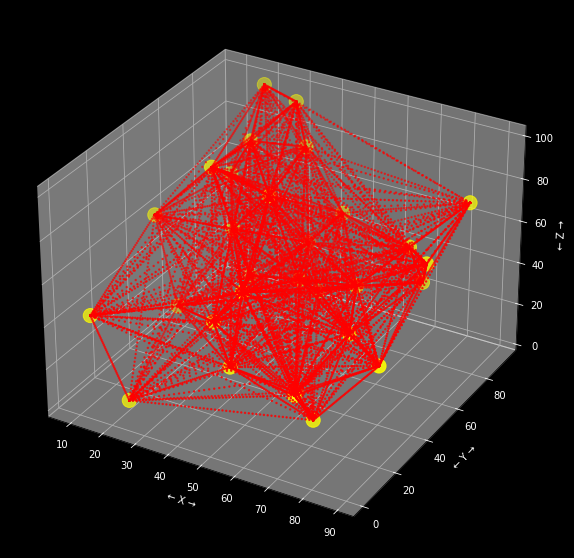

In [288]:
plt.rcParams["xtick.color"] = "white"
plt.figure(figsize=(10, 10), facecolor="black")
ax = plt.axes(projection= '3d', facecolor="black")
ax.scatter3D(X, Y, Z, color="yellow", s=200)
ax.scatter3D(x, y, z, color="red", s=2)
ax.set_xlabel("← X →", color="white")
ax.set_ylabel("← Y →", color="white")
ax.set_zlabel("← Z →", color="white");

COOOL!

Now, but see - the implementation is not perfect. We have to make it Better, Faster and Flexible. <br>
We need to make sure that our SMOTE is such flexible that it can handle `n` number of features. Rather than 3D as here.

In [224]:
# The main and final class

%%writefile SMOTE.py

from sklearn.linear_model import LinearRegression
import numpy as np

class SMOTE:
    """
    This class is the implementation of SMOTE technique of oversampling
    the data points in the imbalanced dataset.
    
    Here I have implemented in the simplest way possible and is dependent
    upon only `numpy` and `sklearn's linear regression`.
    
    About
    -----
    
    After you detect that you have got the problem of imbalanced instances
    per classes, you can simply use this class with ease.
    
    After initializing, SMOTE class's object also has `__repr__` which will
    display useful information.
    
    
    Parameters
    ----------
    
    While initializing:
    ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
        X: DF / ndarray / list
            It must be 2D and numerical in nature.
        
        y: Series / array / list
            It must be 1D and should have categories in it.
            
        oversampling_size: float (between 0 to 1)
            It ensures that how much percentage of highset frequencied class
            you want to generate new samples for. 1 means 100% which means
            total frequences of all class will be same.
    
    
    While Resampling:
    ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
        k: int
            This defines how many neighbours to choose while generating a new
            data point. Default is 5.
    
    
    
    How To
    ------
    
        # Seperate the Features X and Labels Y
        # X should be numerical and 2D.
    >>> X = df[["feature1", "feature2"]]
    ... y = df["target"]
    
    >>> synthesizer = SMOTE(oversampling_size=0.5) # means 50% samples generated.
    >>> synthesizer.resample(k=3)
    
        # ↓ this will return a dict with new data points
    >>> new_data = synthesizer.coords_by_class
    
    
    -- END --
    """
    
    
    def __init__(self, X, y, oversampling_size=1):
        # Simple array transformation
        self.X = np.array(X)
        self.y = np.array(y)
        
        # The length and compatibility checks
        if self.X.ndim != 2:
            raise NotImplementedError("The dimention of X must be 2D.")
        
        if self.X.shape[0] != len(self.y):
            raise NotImplementedError("Length X and Y mismatched.")
        
        if not 0 < oversampling_size <= 1:
            raise NotImplementedError("Oversampling size must be in between 0 to 1.")
        
        # Unique classes and their respective counts
        self.unique_classes, self.unique_count = np.unique(self.y, return_counts=True)
        
        # The max frequency found and multiplied
        # for target frequency generation
        self.to_sample = int(self.unique_count.max() * oversampling_size)
        
        # Total unique classes
        self.nunique = len(self.unique_classes)
        # Total classes which needs oversampling (usually n - 1)
        self.new_generatable = (~(self.unique_count == self.to_sample)).sum()
        
        # Main class with highest freq 
        # (found that 'cause it will be used in next line)
        self.main_class = self.unique_classes[self.unique_count.argmax()]
        # Name of classes to resample (Except the main class)
        self.classes_to_resample = self.unique_classes[self.unique_classes != self.main_class]
        
    
    def resample(self, k=5):
        self.coords_by_class = {}
        # Will iterate through gereratable classes
        for class_ in self.classes_to_resample:
            print(class_)

            # Filter rows to just *that* class
            X_mini = self.X[self.y == class_]
            
            # Fetch class count so we know how much to generate
            class_count = self.unique_count[np.where(self.unique_classes == class_)[0][0]]
            generate_this_many = self.to_sample - class_count

            # Hey, this ↓ should be true.
            assert generate_this_many <= self.to_sample
            # A little check if our "to be generated" class
            # doesn't have less than k instances
            if k >= class_count: k = class_count - 1
                    
            new_coordinates = self.oversample(X_mini, generate_this_many, k)
            self.coords_by_class[class_] = new_coordinates
    
    def oversample(self, X_mini, generate_this_many, k):
        # will have all new generated points `generate_this_many` times
        # and will be returned (per class)
        new_c = []
        
        # will iterate for given times to generate
        # that many.
        for th_sample in range(generate_this_many):
            # One random row
            random_idx = np.random.randint(0, X_mini.shape[0])
            row = X_mini[random_idx]

            # All distances from that row
            distances = ((row - X_mini) ** 2).sum(1) ** 0.5
        
            # `k` neighbours (except itself) 
            sorted_idxes = distances.argsort()[1:k+1]
            k_neighbours = X_mini[sorted_idxes]
            
            # Now picking 1 random neighbor
            rand_neighbour = np.random.randint(0, k)
            neighbour = k_neighbours[rand_neighbour]

            # We have point A's corrs (features)
            # And poinf B's corrs (features)
            B0, Bi = self.get_regression_line(row, neighbour)
            
            # It will handle X1, X2 ... Xn-1 features
            # Xn will be our y (to be predicted)
            new_coordinates = []
            # We will iterate through 2 rows (always 2 
            # as 2 points A and B)
            for p1, p2 in zip(row[:-1], neighbour[:-1]):
                # Get new random coord
                new_coordinates.append(np.random.uniform(p1, p2))
            
            # This will take new coords [X1...Xn-1] along
            # with B0 and Bi to generate the y
            y = self.generator(new_coordinates, B0, Bi)
            
            # Will append in the new coords [X1...Xn-1, Xn]
            new_coordinates.append(y)
            # Appends whole coordinate till `th` times
            new_c.append(new_coordinates)
        return new_c
        
    
    def get_regression_line(self, A, B):
        # Stacking 2 rows for easier access
        data = np.vstack([A, B])
        
        # Make the last column as `y`
        X = data[:, :-1]
        y = data[:, -1]
        
        # Learn the model for 2 rows.
        model = LinearRegression()
        model.fit(X, y)
        B0 = model.intercept_
        Bi = model.coef_
        return B0, Bi
        
        
    @staticmethod
    def generator(new_coords, B0, Bi):
        return B0 + (new_coords * Bi).sum()
    
        
    def __repr__(self):
        return \
        f"""
        Number of features: {self.X.shape[1]}
        Total unique classes: {self.nunique}
        New instances to generate for: {self.new_generatable} class(s)
        Total class balance: {self.to_sample}
        Class with highest instances: {self.main_class}
        """

Writing SMOTE.py


In [ ]:
resample = SMOTE(df[["x1", "x2", "x3"]], df["y"])
resample

In [414]:
resample.resample()

B
C
D


In [419]:
new_b = np.array(resample.corr_by_class["B"])
Xb, Yb, Zb = new_b[:, 0], new_b[:, 1], new_b[:, 2]

new_c = np.array(resample.corr_by_class["C"])
Xc, Yc, Zc = new_c[:, 0], new_c[:, 1], new_c[:, 2]

new_d = np.array(resample.corr_by_class["D"])
Xd, Yd, Zd = new_d[:, 0], new_d[:, 1], new_d[:, 2]

In [432]:
%matplotlib inline

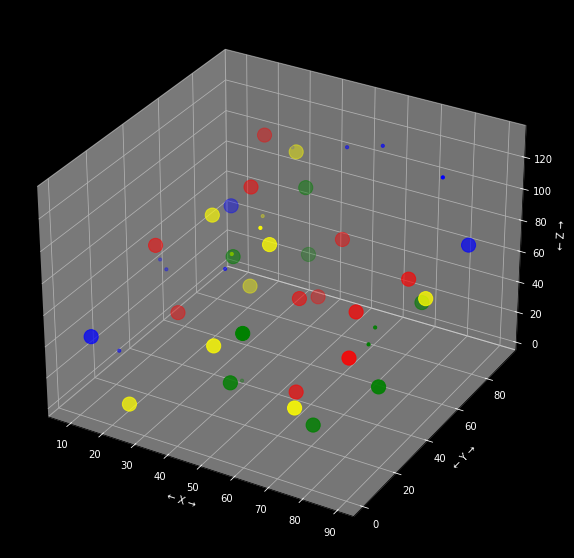

In [433]:
plt.rcParams["xtick.color"] = "white"
plt.figure(figsize=(10, 10), facecolor="black")
ax = plt.axes(projection= '3d', facecolor="black")

color = df.y.map({"A":"red", "B":"blue", "C":"green", "D":"yellow"})
ax.scatter3D(df.x1, df.x2, df.x3, s=200, c=color)
ax.scatter3D(Xb, Yb, Zb, color="blue", s=10)
ax.scatter3D(Xc, Yc, Zc, color="green", s=10)
ax.scatter3D(Xd, Yd, Zd, color="yellow", s=10)
ax.set_xlabel("← X →", color="white")
ax.set_ylabel("← Y →", color="white")
ax.set_zlabel("← Z →", color="white");

Alrighty! Works! <br>
Now, let's do this on some more busy dataset.

In [40]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                            n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

In [41]:
counts = pd.value_counts(y)
counts

0    9900
1     100
dtype: int64

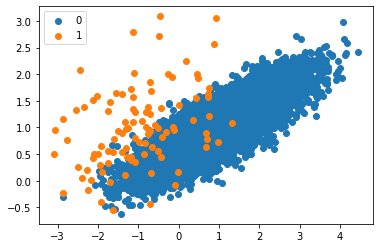

In [42]:
for label, _ in counts.items():
	row_ix = np.where(y == label)[0]
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [51]:
resample = SMOTE(X, y)
resample


        Number of features: 2
        Total unique classes: 2
        New instances to generate for: 1 class(s)
        Total class balance: 9900
        Class with highest instances: 0
        

In [52]:
resample.resample()

1


In [53]:
for class_ in resample.corr_by_class:
    print(class_, len(resample.corr_by_class[class_]))

1 9800


In [54]:
pd.value_counts(y)

0    9900
1     100
dtype: int64

So, 100 + 9800 = 9900.  
Hence, 0 and 1 both are having same number of instances.

Worked!

In [57]:
new = np.array(resample.corr_by_class[1])
new_X, new_Y = new[:, 0], new[:, 1]

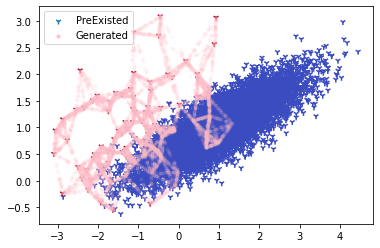

In [75]:
plt.scatter(X[:, 0], X[:, 1], c=y, marker="1", cmap="coolwarm", label="PreExisted")
plt.scatter(new_X, new_Y, c="pink", marker=".", alpha=0.1)
plt.scatter([], [], c="pink", label="Generated", marker='.')
plt.legend();

Amazing!! We have done it. Really.

Let's go for 3 different classes and try to generate the datapoints.

In [93]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                            n_clusters_per_class=1, weights=[0.99, 0.4], random_state=1,
                            n_classes=3)

counts = pd.value_counts(y)
counts

0    979
1     16
2      5
dtype: int64

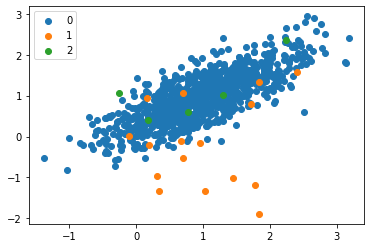

In [94]:
for label, _ in counts.items():
	row_ix = np.where(y == label)[0]
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [95]:
resample = SMOTE(X, y)
resample


        Number of features: 2
        Total unique classes: 3
        New instances to generate for: 2 class(s)
        Total class balance: 979
        Class with highest instances: 0
        

In [96]:
resample.resample()

1
2


In [97]:
for class_ in resample.corr_by_class:
    print(class_, len(resample.corr_by_class[class_]))

1 963
2 974


In [98]:
pd.value_counts(y)

0    979
1     16
2      5
dtype: int64

In [99]:
16 + 963

979

In [100]:
5 + 974

979

Yep, it adds them up.

In [101]:
new = np.array(resample.corr_by_class[1])
new_X1, new_Y1 = new[:, 0], new[:, 1]

new = np.array(resample.corr_by_class[2])
new_X2, new_Y2 = new[:, 0], new[:, 1]

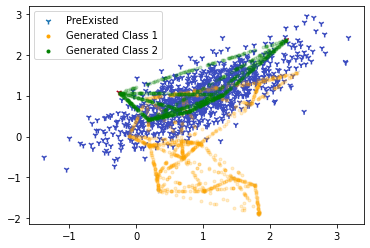

In [105]:
plt.scatter(X[:, 0], X[:, 1], c=y, marker="1", cmap="coolwarm", label="PreExisted")
plt.scatter(new_X1, new_Y1, c="orange", marker=".", alpha=0.2)
plt.scatter(new_X2, new_Y2, c="green", marker=".", alpha=0.2)
plt.scatter([], [], c="orange", label="Generated Class 1", marker='.')
plt.scatter([], [], c="green", label="Generated Class 2", marker='.')
plt.legend();

WORRRKKKSS!!!

### Trying with 3D (3 Features)

In [113]:
X, Y = make_classification(n_samples=1000, n_features=3, n_redundant=0,
                            n_clusters_per_class=1, weights=[0.99, 0.4], random_state=1,
                            n_classes=3)

counts = pd.value_counts(Y)
counts

0    985
1     11
2      4
dtype: int64

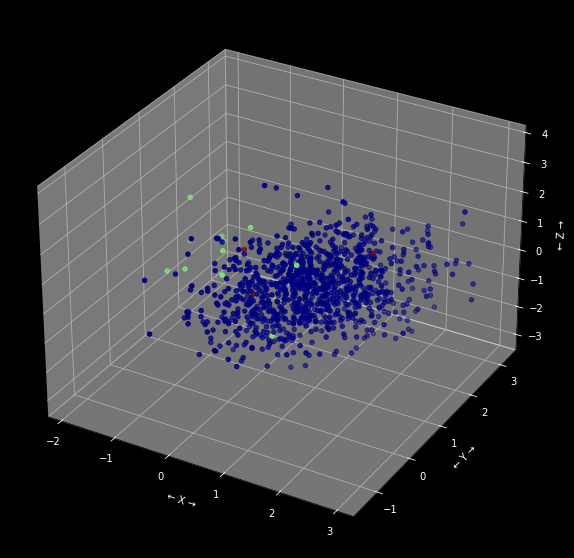

In [123]:
from mpl_toolkits import mplot3d

plt.rcParams["xtick.color"] = "white"
plt.figure(figsize=(10, 10), facecolor="black")

x = X[:, 0]
y = X[:, 1]
z = X[:, 2]


ax = plt.axes(projection= '3d', facecolor="black")
ax.scatter3D(x, y, z, c=Y, s=20, cmap="jet")


ax.set_xlabel("← X →", color="white")
ax.set_ylabel("← Y →", color="white")
ax.set_zlabel("← Z →", color="white");

In [125]:
resample = SMOTE(X, Y)
resample


        Number of features: 3
        Total unique classes: 3
        New instances to generate for: 2 class(s)
        Total class balance: 985
        Class with highest instances: 0
        

In [126]:
resample.resample()

1
2


In [127]:
for class_ in resample.corr_by_class:
    print(class_, len(resample.corr_by_class[class_]))

1 974
2 981


In [129]:
pd.value_counts(Y)

0    985
1     11
2      4
dtype: int64

In [130]:
11 + 974

985

In [131]:
4 + 981

985

Yep, it adds them up.

In [132]:
new = np.array(resample.corr_by_class[1])
new_X1, new_Y1, new_Z1 = new[:, 0], new[:, 1], new[:, 2]

new = np.array(resample.corr_by_class[2])
new_X2, new_Y2, new_Z2 = new[:, 0], new[:, 1], new[:, 2]

In [146]:
%matplotlib inline

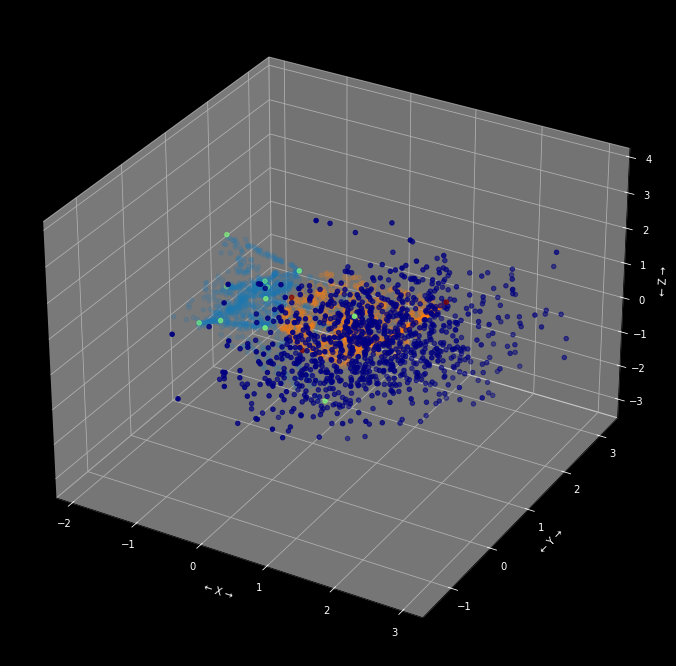

In [150]:
plt.rcParams["xtick.color"] = "white"
plt.figure(figsize=(12, 12), facecolor="black")


ax = plt.axes(projection= '3d', facecolor="black")
ax.scatter3D(x, y, z, c=Y, s=20, cmap="jet")
ax.scatter3D(new_X1, new_Y1, new_Z1, s=20, alpha=0.2)
ax.scatter3D(new_X2, new_Y2, new_Z2, s=20, cmap="jet", alpha=0.2)



ax.set_xlabel("← X →", color="white")
ax.set_ylabel("← Y →", color="white")
ax.set_zlabel("← Z →", color="white");

It does work! You have to look in 3D to realize that it is working!!

Okay... one more time. This time we will plot for the **real world dataset**. Let's try our hands on the tips.

In [151]:
import seaborn as sns

In [173]:
iris = sns.load_dataset("iris")

In [176]:
copy = iris[iris.species == "setosa"].copy()

In [196]:
altered_features = []
for col in iris.columns[:-1]:
    min_ = copy[col].min()
    max_ = copy[col].max()
    altered_features.append(copy[col] + np.random.uniform(min_, max_ - 2, len(copy[col])))

In [197]:
altered_features = pd.concat(altered_features, axis=1)
altered_features["species"] = "setosa"
altered_features.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,9.326383,5.861319,1.607494,-0.302520,setosa
1,8.774210,5.394730,1.891746,-0.723288,setosa
2,8.576204,5.526592,1.570925,-0.952874,setosa
3,8.551110,5.444614,1.407034,-0.714211,setosa
4,8.903663,5.913992,1.861718,-0.476668,setosa


In [198]:
iris = pd.concat([iris, altered_features])

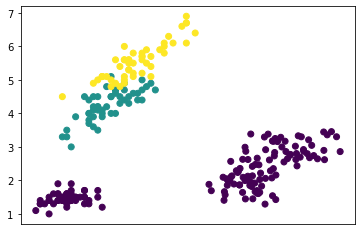

In [199]:
plt.scatter(iris.sepal_length, iris.petal_length, c=pd.Categorical(iris.species).codes)

In [200]:
iris.species.value_counts()

setosa        150
virginica      50
versicolor     50
Name: species, dtype: int64

Clearly, now we have to generate 100 samples for both classes.

In [201]:
X = iris.drop("species", axis=1)
y = iris["species"]

In [202]:
resample = SMOTE(X, y)
resample


        Number of features: 4
        Total unique classes: 3
        New instances to generate for: 2 class(s)
        Total class balance: 150
        Class with highest instances: setosa
        

In [203]:
resample.resample()

versicolor
virginica


In [205]:
new_versi = resample.corr_by_class["versicolor"]
new_virgi = resample.corr_by_class["virginica"]

In [208]:
new_versi = pd.DataFrame(new_versi, columns=iris.columns[:-1])
new_virgi = pd.DataFrame(new_virgi, columns=iris.columns[:-1])

In [209]:
new_versi["species"] = "versicolor"
new_virgi["species"] = "virginica"

In [212]:
synthesized = pd.concat([iris, new_versi, new_virgi])
synthesized.shape

(450, 5)

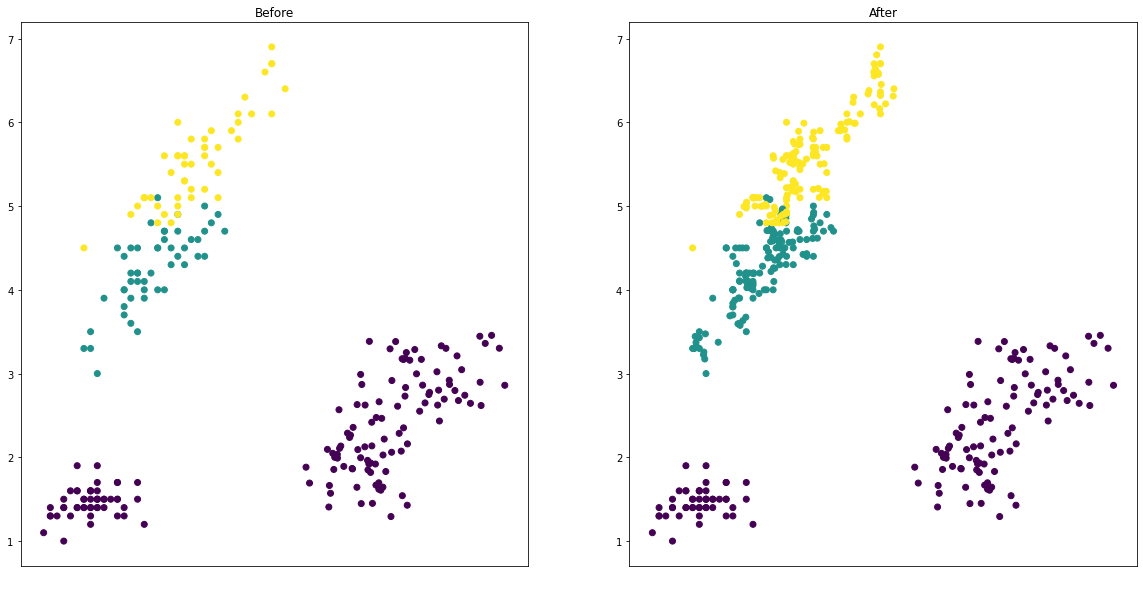

In [222]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].scatter(iris.sepal_length, iris.petal_length, c=pd.Categorical(iris.species).codes)
axes[0].set_title("Before")

axes[1].scatter(synthesized.sepal_length, synthesized.petal_length, c=pd.Categorical(synthesized.species).codes)
axes[1].set_title("After");

In [223]:
synthesized.species.value_counts()

virginica     150
versicolor    150
setosa        150
Name: species, dtype: int64

# 

# Great!
There is the seperate file for SMOTE. We can access directly from there.

Thanks!<br>
Aayush ∞ Shah